In [ ]:
import requests
import bs4 as bs
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt

In [ ]:
foursquare_api_count = 0

In [ ]:
def get_venues(coords):
  global foursquare_api_count
  VERSION = '20180605'

  limit  = 100 # limit of number of venues returned by Foursquare API
  radius = 500 # define radius

  venues = {}

  for c in coords:
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
      CLIENT_ID[min(foursquare_api_count//500, len(CLIENT_ID))],     # multiple client ids to get around 500 api hit limit
      CLIENT_SECRET[min(foursquare_api_count//500, len(CLIENT_SECRET))], 
      VERSION, 
      c[0], 
      c[1], 
      radius, 
      limit)
    foursquare_api_count += 1
    res = requests.get(url).json()

    try:
      # parse response
      for venue in res['response']['groups'][0]['items']:
        venue  = venue['venue']
        id     = venue['id']
        name   = venue['name']
        coords = venue['location']

        latitude  = coords['lat']
        longitude = coords['lng']

        category = []
        if 'categories' in venue:
          category = venue['categories']
        elif 'venue.categories' in venue:
          category = venue['venue.categories']
        if len(category) == 0:
          category = None
        else:
          category = category[0]['name']

        venues[id] = {
            'Name': name,
            'Category': category,
            'Latitude': latitude,
            'Longitude': longitude,
        }
    except Exception as e:
      print(e)
      print(res)
    
    return list(venues.values())

In [ ]:
def coords_avg(coords):
  lat  = [float(c[0]) for c in coords]
  long = [float(c[1]) for c in coords]
  leng = len(coords)

  return (sum(lat)/leng, sum(long)/leng)

In [ ]:
def get_london_data():
  res  = requests.get('https://en.wikipedia.org/wiki/List_of_areas_of_London')
  soup = bs.BeautifulSoup(res.content,'lxml')

  wiki_table = soup.findAll('table')[1]
  data = []

  #constructing the table
  table_df = pd.DataFrame()
  # skip header
  for row in wiki_table.findAll('tr')[1:]:
    row = row.findAll('td')

    nhood   = row[0].text
    borough = row[1].text
    coords  = row[-1].span.a['href'].split('params=')[-1].split('_')
    lat     = str(float(coords[0]) * (-1 if coords[1]=='S' else 1)) # parse lat long to +/- format
    long    = str(float(coords[2]) * (-1 if coords[3]=='W' else 1))

    data.append({
      'Neighbourhood': nhood,
      'Borough': borough,
      'Coordinates': [(lat, long)],
      'Latitude': float(lat),
      'Longitude': float(long),
    })
  
  return data

london = get_london_data()

In [ ]:
def get_ny_coordinates(zipcode):
  url   = 'http://www.geonames.org/postalcode-search.html?q='+zipcode+'&country=US'
  res   = requests.get(url)
  soup  = bs.BeautifulSoup(res.content, 'lxml')
  table = soup.findAll('table', {'class': 'restable'})[0]

  coords = []
  # skip header and skip every other row (get only coords)
  for row in table.findAll('tr')[2::2]:
    row = row.find('small').text.split('/')
    coords.append((row[0], row[1]))
  
  return coords
  

def get_ny_data():
  ny = [
    ['Bronx', 'Kingsbridge - Riverdale',
      ['10463', '10471']],
    ['Bronx', 'Northeast Bronx',
      ['10466', '10469', '10470', '10475']],
    ['Bronx', 'Fordham - Bronx Park',
      ['10458', '10467', '10468']],
    ['Bronx', 'Pelham - Throgs Neck',
      ['10461', '10462', '10464', '10465', '10472', '10473']],
    ['Bronx', 'Crotona - Tremont',
      ['10453', '10457', '10460']],
    ['Bronx', 'High Bridge - Morrisania',
      ['10451', '10452', '10456']],
    ['Bronx', 'Hunts Point - Mott Haven',
      ['10454', '10455', '10459', '10474']],
    ['Brooklyn', 'Greenpoint',
      ['11211', '11222']],
    ['Brooklyn', 'Downtown - Heights - Park Slope',
      ['11201', '11205', '11215', '11217', '11231']],
    ['Brooklyn', 'Bedford Stuyvesant - Crown Heights',
      ['11213', '11212', '11216', '11233', '11238']],
    ['Brooklyn', 'East New York',
      ['11207', '11208']],
    ['Brooklyn', 'Sunset Park',
      ['11220', '11232']],
    ['Brooklyn', 'Borough Park',
      ['11204', '11218', '11219', '11230']],
    ['Brooklyn', 'East Flatbush - Flatbush',
      ['11203', '11210', '11225', '11226']],
    ['Brooklyn', 'Canarsie - Flatlands',
      ['11234', '11236', '11239']],
    ['Brooklyn', 'Bensonhurst - Bay Ridge',
      ['11209', '11214', '11228']],
    ['Brooklyn', 'Coney Island - Sheepshead Bay',
      ['11223', '11224', '11229', '11235']],
    ['Brooklyn', 'Williamsburg - Bushwick',
      ['11206', '11221', '11237']],
    ['Manhattan', 'Washington Heights - Inwood',
      ['10031', '10032', '10033', '10034', '10040']],
    ['Manhattan', 'Central Harlem - Morningside Heights',
      ['10026', '10027', '10030', '10037', '10039']],
    ['Manhattan', 'East Harlem',
      ['10029', '10035']],
    ['Manhattan', 'Upper West Side',
      ['10023', '10024', '10025']],
    ['Manhattan', 'Upper East Side',
      ['10021', '10028', '10044', '10128']],
    ['Manhattan', 'Chelsea - Clinton',
      ['10001', '10011', '10018', '10019', '10020', '10036']],
    ['Manhattan', 'Gramercy Park - Murray Hill',
      ['10010', '10016', '10017', '10022']],
    ['Manhattan', 'Greenwich Village - SoHo',
      ['10012', '10013', '10014']],
    ['Manhattan', 'Union Square - Lower East Side',
      ['10002', '10003', '10009']],
    ['Manhattan', 'Lower Manhattan',
      ['10004', '10005', '10006', '10007', '10038', '10280']],
    ['Queens', 'Long Island City - Astoria',
      ['11101', '11102', '11103', '11104', '11105', '11106']],
    ['Queens', 'West Queens',
      ['11368', '11369', '11370', '11372', '11373', '11377', '11378']],
    ['Queens', 'Flushing - Clearview',
      ['11354', '11355', '11356', '11357', '11358', '11359', '11360']],
    ['Queens', 'Bayside - Little Neck',
      ['11361', '11362', '11363', '11364']],
    ['Queens', 'Ridgewood - Forest Hills',
      ['11374', '11375', '11379', '11385']],
    ['Queens', 'Fresh Meadows',
      ['11365', '11366', '11367']],
    ['Queens', 'Southwest Queens',
      ['11414', '11415', '11416', '11417', '11418', '11419', '11420', '11421']],
    ['Queens', 'Jamaica',
      ['11412', '11423', '11432', '11433', '11434', '11435', '11436']],
    ['Queens', 'Southeast Queens',
      ['11004', '11005', '11411', '11413', '11422', '11426', '11427', '11428', '11429']],
    ['Queens', 'Rockaway',
      ['11691', '11692', '11693', '11694', '11695', '11697']],
    ['Staten Island', 'Port Richmond',
      ['10302', '10303', '10310']],
    ['Staten Island', 'Stapleton - St. George',
      ['10301', '10304', '10305']],
    ['Staten Island', 'Willowbrook',
      ['10314']],
    ['Staten Island', 'South Beach - Tottenville',
      ['10306', '10307', '10308', '10309', '10312']],
  ]
  
  data = []

  for nhood in ny:
    borough  = nhood[0]
    zipcodes = nhood[2]
    nhood    = nhood[1]

    coords = []
    for z in zipcodes:
      c = get_ny_coordinates(z)
      coords += c

    data.append({
        'Neighbourhood': nhood,
        'Borough': borough,
        'Coordinates': coords,
        'Latitude': float(coords_avg(coords)[0]), # use avg of all zipcodes coords for neighbourhood coords
        'Longitude': float(coords_avg(coords)[1]),
    })
  
  return data

new_york = get_ny_data()

In [ ]:
def get_toronto_data():
  #obtaining data from wikipedia.org
  url   = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
  res   = requests.get(url)
  soup  = bs.BeautifulSoup(res.content, 'lxml')
  table = soup.find('table')

  #constructing the table
  df = pd.DataFrame()
  not_assigned = 0
  for row in table.findAll('td'):
    cell = {}
    if row.span.text == 'Not assigned':
      not_assigned += 1
    else:
      cell['PostalCode'] = row.p.text[:3]
      cell['Borough'] = row.span.text.split('(')[0]
      cell['Neighbourhood'] = row.span.text.split('(')[1].strip(')').replace(' /', ',').replace(')', ' ').strip(' ')
      df = df.append(cell, ignore_index=True)

  #downloading geospatial data
  geospatial_url  = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv"
  geospatial_data = pd.read_csv(geospatial_url)
  geospatial_data.columns = ['PostalCode', 'Latitude', 'Longitude']

  merged_data = pd.merge(df, geospatial_data, on='PostalCode')
  
  data = []
  for _, row in merged_data.iterrows():
    data.append({
        'Neighbourhood': row['Neighbourhood'],
        'Borough': row['Borough'],
        'Coordinates': [(row['Latitude'], row['Longitude'])],
        'Latitude': row['Latitude'],
        'Longitude': row['Longitude'],
    })
  
  return data, not_assigned

toronto, toronto_not_assigned = get_toronto_data()

In [ ]:
london_venues = []
# TODO: get all
for nhood in london:
  venues = get_venues(nhood['Coordinates'])
  for venue in venues:
    london_venues.append([
      nhood['Neighbourhood'],
      coords_avg(nhood['Coordinates'])[0],
      coords_avg(nhood['Coordinates'])[1],
      venue['Name'],
      venue['Latitude'],
      venue['Longitude'],
      venue['Category'],
    ])

london_venues = pd.DataFrame(london_venues)
london_venues.columns = [
  'Neighbourhood', 
  'Neighbourhood Latitude', 
  'Neighbourhood Longitude', 
  'Venue', 
  'Venue Latitude', 
  'Venue Longitude', 
  'Venue Category']
  
london_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.486480,0.108592,Co-op Food,51.487490,0.113751,Grocery Store
1,Abbey Wood,51.486480,0.108592,Morley's,51.485610,0.102389,Fried Chicken Joint
2,Abbey Wood,51.486480,0.108592,East Ocean,51.485279,0.102426,Chinese Restaurant
3,Abbey Wood,51.486480,0.108592,Meghna Tandoori,51.485709,0.101681,Indian Restaurant
4,Acton,51.510588,-0.264989,The Station House,51.508877,-0.263076,Pub


In [ ]:
ny_venues = []
# TODO: get all
for nhood in new_york:
  venues = get_venues(nhood['Coordinates'])
  for venue in venues:
    ny_venues.append([
      nhood['Neighbourhood'],
      coords_avg(nhood['Coordinates'])[0],  
      coords_avg(nhood['Coordinates'])[1],
      venue['Name'],
      venue['Latitude'],
      venue['Longitude'],
      venue['Category'],
    ])

ny_venues = pd.DataFrame(ny_venues)
ny_venues.columns = [
  'Neighbourhood', 
  'Neighbourhood Latitude', 
  'Neighbourhood Longitude', 
  'Venue', 
  'Venue Latitude', 
  'Venue Longitude', 
  'Venue Category']
  
ny_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Kingsbridge - Riverdale,40.8905,-73.906,Sam's Pizza,40.879435,-73.905859,Pizza Place
1,Kingsbridge - Riverdale,40.8905,-73.906,Tibbett Diner,40.880404,-73.908937,Diner
2,Kingsbridge - Riverdale,40.8905,-73.906,El Malecon,40.879338,-73.904457,Caribbean Restaurant
3,Kingsbridge - Riverdale,40.8905,-73.906,Estrellita Poblana V,40.879687,-73.906257,Mexican Restaurant
4,Kingsbridge - Riverdale,40.8905,-73.906,Garden Gourmet Market,40.881350,-73.903389,Gourmet Shop


In [ ]:
toronto_venues = []
# TODO: get all
for nhood in toronto:
  venues = get_venues(nhood['Coordinates'])
  for venue in venues:
    toronto_venues.append([
      nhood['Neighbourhood'],
      coords_avg(nhood['Coordinates'])[0],  
      coords_avg(nhood['Coordinates'])[1],
      venue['Name'],
      venue['Latitude'],
      venue['Longitude'],
      venue['Category'],
    ])

toronto_venues = pd.DataFrame(toronto_venues)
toronto_venues.columns = [
  'Neighbourhood', 
  'Neighbourhood Latitude', 
  'Neighbourhood Longitude', 
  'Venue', 
  'Venue Latitude', 
  'Venue Longitude', 
  'Venue Category']
  
toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


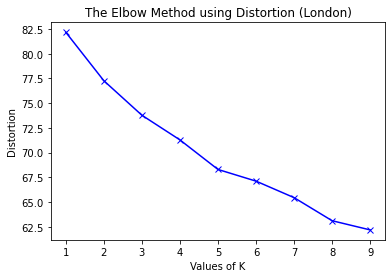

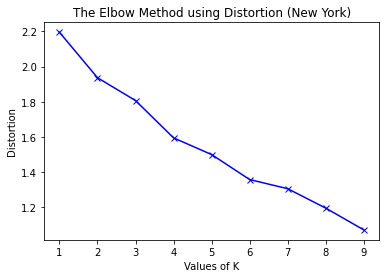

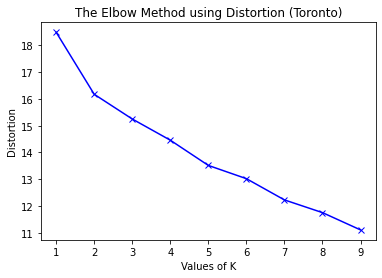

In [ ]:
def show_elbow_method_plot(city_name, venues):
  # one hot encoding
  city_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

  # add neighbourhood column back to dataframe
  city_onehot.insert(0, 'Neighbourhood', venues['Neighbourhood'])
  city_grouped = city_onehot.groupby('Neighbourhood').mean().reset_index()
  city_grouped_clustering = city_grouped.drop('Neighbourhood', 1)

  distortions = []
  for k in range(1, 10):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(city_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

  plt.plot(range(1, 10), distortions, 'bx-')
  plt.xlabel('Values of K')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method using Distortion ('+city_name+')')
  plt.show()

show_elbow_method_plot('London', london_venues)
show_elbow_method_plot('New York', ny_venues)
show_elbow_method_plot('Toronto', toronto_venues)

In [ ]:
def get_most_common(city, venues, kclusters=3):
  # one hot encoding
  city_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

  # add neighbourhood column back to dataframe
  city_onehot.insert(0, 'Neighbourhood', venues['Neighbourhood'])

  city_grouped = city_onehot.groupby('Neighbourhood').mean().reset_index()

  num_top_venues = min(10, city_grouped.shape[1]-1)

  indicators = ['st', 'nd', 'rd']
  columns = ['Neighbourhood']
  for i in range(1, num_top_venues+1):
      columns.append('{}{} Most Common'.format(i, indicators[i-1] if i<3 else 'th') + (' Category' if i==1 else ''))

  # create a new dataframe
  neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
  neighbourhoods_venues_sorted['Neighbourhood'] = city_grouped['Neighbourhood']

  for i in np.arange(city_grouped.shape[0]):
    row_categories = city_grouped.iloc[i, :].iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighbourhoods_venues_sorted.iloc[i, 1:] = row_categories_sorted.index.values[0:num_top_venues]

  city_grouped_clustering = city_grouped.drop('Neighbourhood', 1)

  # run k-means clustering
  kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

  # add clustering labels
  neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

  city_merged = pd.DataFrame(data=city)  

  # merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighbourhood
  city_merged = city_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
  city_merged = city_merged.drop('Coordinates', 1)

  # count how many venues a neighbourhood has
  venue_count = {}
  for _, venue in venues.iterrows():
    nbhood = venue['Neighbourhood']
    if nbhood not in venue_count:
      venue_count[nbhood] = 0
    venue_count[nbhood] += 1
  
  # add venue count and sort by it
  neighbourhoods_venues_sorted.insert(2, 'Venue Count', [venue_count.get(n, 0) for n in neighbourhoods_venues_sorted['Neighbourhood']])
  neighbourhoods_venues_sorted = neighbourhoods_venues_sorted.sort_values('Venue Count', ascending=False, ignore_index=True)

  return city_merged, neighbourhoods_venues_sorted

In [ ]:
london_merged_with_nan, london_sorted = get_most_common(london, london_venues, kclusters=5)

# drop NaN rows (no venues in the area)
london_merged = london_merged_with_nan.dropna()
london_sorted[:50]

,Cluster Labels,Neighbourhood,Venue Count,1st Most Common Category,2nd Most Common,3th Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
0,2,St Luke's,100,Coffee Shop,Food Truck,Gym / Fitness Center,Pub,Café,Italian Restaurant,Bar,Park,Hotel,Ramen Restaurant
1,2,St Pancras,100,Hotel,Coffee Shop,Café,Pub,Hotel Bar,Park,Sandwich Place,Bakery,Bookstore,Italian Restaurant
2,2,Covent Garden,100,Bakery,Coffee Shop,Ice Cream Shop,Theater,French Restaurant,Wine Bar,Hotel,Pub,Clothing Store,Burger Joint
3,2,Spitalfields,100,Coffee Shop,Pub,Hotel,Cocktail Bar,Sandwich Place,Thai Restaurant,Restaurant,Food Truck,Café,Gym / Fitness Center
4,2,Chinatown,100,Theater,Bakery,Cocktail Bar,Ice Cream Shop,Italian Restaurant,Seafood Restaurant,Liquor Store,Multiplex,Speakeasy,Gourmet Shop
5,2,Charing Cross,100,Theater,Hotel,Coffee Shop,French Restaurant,Bakery,Burger Joint,Wine Bar,Pub,Bookstore,Event Space
6,2,Marylebone (also St Marylebone),100,French Restaurant,Bakery,Clothing Store,Pub,Juice Bar,Burger Joint,Sandwich Place,Cosmetics Shop,Café,Coffee Shop
7,2,Canary Wharf,100,Coffee Shop,Sandwich Place,Burger Joint,Italian Restaurant,Park,Café,Shopping Mall,Plaza,Bakery,Gift Shop
8,2,Kingston upon Thames,100,Coffee Shop,Café,Pub,Clothing Store,Thai Restaurant,Department Store,Bakery,Sandwich Place,Italian Restaurant,Hotel
9,2,St James's,100,Hotel,Boutique,Theater,Cocktail Bar,Lounge,Steakhouse,Italian Restaurant,Coffee Shop,Indian Restaurant,Art Museum


In [ ]:
ny_merged_with_nan, ny_sorted = get_most_common(new_york, ny_venues, kclusters=4)

# drop NaN rows (no venues in the area)
ny_merged = ny_merged_with_nan.dropna()
ny_sorted

,Cluster Labels,Neighbourhood,Venue Count,1st Most Common Category,2nd Most Common,3th Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
0,0,Greenwich Village - SoHo,100,Italian Restaurant,Boutique,Clothing Store,Sushi Restaurant,Coffee Shop,Café,Spa,Sporting Goods Shop,Cosmetics Shop,Bakery
1,0,Chelsea - Clinton,100,Coffee Shop,Gym / Fitness Center,Sushi Restaurant,Bakery,Bar,Grocery Store,Gym,Lounge,Chinese Restaurant,Café
2,0,Union Square - Lower East Side,100,Bakery,Mexican Restaurant,Bar,Chinese Restaurant,American Restaurant,Coffee Shop,Dumpling Restaurant,Cocktail Bar,Sandwich Place,Spanish Restaurant
3,0,Lower Manhattan,100,Coffee Shop,Gym / Fitness Center,Park,Italian Restaurant,Spa,American Restaurant,Bakery,Sandwich Place,Gym,Hotel Bar
4,0,Upper West Side,100,Theater,Coffee Shop,Italian Restaurant,Gym / Fitness Center,Concert Hall,American Restaurant,Yoga Studio,Indie Movie Theater,Juice Bar,Performing Arts Venue
5,0,Upper East Side,100,Italian Restaurant,Coffee Shop,Sushi Restaurant,Café,Pizza Place,Cocktail Bar,Burger Joint,Gym,Gym / Fitness Center,Salon / Barbershop
6,0,Bensonhurst - Bay Ridge,100,Italian Restaurant,Cosmetics Shop,Spa,Pizza Place,Bar,Bagel Shop,Pharmacy,Greek Restaurant,Diner,Supplement Shop
7,0,Gramercy Park - Murray Hill,87,Wine Shop,Bagel Shop,Pizza Place,Italian Restaurant,Café,Cocktail Bar,Deli / Bodega,Bar,Mexican Restaurant,Diner
8,0,Bayside - Little Neck,83,Bar,Sushi Restaurant,Pizza Place,Pharmacy,Mexican Restaurant,Indian Restaurant,Bakery,American Restaurant,Asian Restaurant,Greek Restaurant
9,0,Downtown - Heights - Park Slope,78,Park,Yoga Studio,Gym,Plaza,Bagel Shop,Deli / Bodega,Asian Restaurant,Burger Joint,Pizza Place,Gym / Fitness Center


In [ ]:
toronto_merged_with_nan, toronto_sorted = get_most_common(toronto, toronto_venues, kclusters=5)

# drop NaN rows (no venues in the area)
toronto_merged = toronto_merged_with_nan.dropna()
toronto_sorted[:50]

,Cluster Labels,Neighbourhood,Venue Count,1st Most Common Category,2nd Most Common,3th Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
0,1,"First Canadian Place, Underground city",100,Coffee Shop,Café,Hotel,Restaurant,Gym,Japanese Restaurant,Asian Restaurant,Deli / Bodega,Salad Place,Bakery
1,1,"Richmond, Adelaide, King",100,Coffee Shop,Café,Thai Restaurant,Restaurant,Hotel,Deli / Bodega,Clothing Store,Gym,Pizza Place,Cosmetics Shop
2,1,"Harbourfront East, Union Station, Toronto Islands",100,Coffee Shop,Aquarium,Café,Hotel,Fried Chicken Joint,Restaurant,Italian Restaurant,Brewery,Scenic Lookout,Bakery
3,1,"Toronto Dominion Centre, Design Exchange",100,Coffee Shop,Café,Hotel,Restaurant,Seafood Restaurant,Bakery,Salad Place,Italian Restaurant,Japanese Restaurant,Concert Hall
4,1,"Commerce Court, Victoria Hotel",100,Coffee Shop,Restaurant,Café,Hotel,Gym,American Restaurant,Bakery,Japanese Restaurant,Deli / Bodega,Seafood Restaurant
5,1,"Garden District, Ryerson",100,Coffee Shop,Clothing Store,Café,Bubble Tea Shop,Japanese Restaurant,Middle Eastern Restaurant,Cosmetics Shop,Hotel,Theater,Italian Restaurant
6,1,Enclave of M5E,97,Coffee Shop,Italian Restaurant,Seafood Restaurant,Restaurant,Pub,Café,Bakery,Japanese Restaurant,Cocktail Bar,Breakfast Spot
7,1,St. James Town,82,Coffee Shop,Café,Cocktail Bar,Cosmetics Shop,Gastropub,Restaurant,Gym,Farmers Market,Seafood Restaurant,Italian Restaurant
8,1,Church and Wellesley,80,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Hotel,Fast Food Restaurant,Pub,Yoga Studio,Men's Store
9,1,"Kensington Market, Chinatown, Grange Park",67,Café,Bar,Coffee Shop,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Gaming Cafe,Bakery,Burger Joint,Arts & Crafts Store,Caribbean Restaurant


In [ ]:
def create_nbhood_map(merged, lat, long, kclusters=3):
  map_clusters = folium.Map(location=[lat, long], zoom_start=11)

  # set color scheme for the clusters
  x = np.arange(kclusters)
  ys = [i + x + (i*x)**2 for i in range(kclusters)]
  colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
  rainbow = [colors.rgb2hex(i) for i in colors_array]

  merged = merged
  # add markers to the map
  markers_colors = []
  for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighbourhood'], merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
  
  return map_clusters

In [ ]:
create_nbhood_map(london_merged, 51.509865, -0.118092, kclusters=5)

In [ ]:
create_nbhood_map(ny_merged, 40.730610, -73.935242, kclusters=4)

In [ ]:
create_nbhood_map(toronto_merged, 43.651070, -79.347015, kclusters=5)

In [ ]:
print('Toronto Not Assigned: '+str(toronto_not_assigned))
pd.DataFrame({
    'City': [
             'London',
             'New York',
             'Toronto',
    ],
    'NaN Rows': [
                 london_merged_with_nan.shape[0]-london_merged.shape[0],
                 ny_merged_with_nan.shape[0]-ny_merged.shape[0],
                 toronto_merged_with_nan.shape[0]-toronto_merged.shape[0],
    ],
    'Cleaned up Rows': [
                        london_merged.shape[0],
                        ny_merged.shape[0],
                        toronto_merged.shape[0],
    ],
    'Total Rows': [
                   london_merged_with_nan.shape[0],
                   ny_merged_with_nan.shape[0],
                   toronto_merged_with_nan.shape[0],
    ],
})

Toronto Not Assigned: 77


,City,NaN Rows,Cleaned up Rows,Total Rows
0,London,4,527,531
1,New York,0,42,42
2,Toronto,3,100,103


# London With K Cluster 5
![london_k_5](https://github.com/canesceline/Coursera_Capstone/blob/main/London%205.jpg?raw=true)
# New York With K Cluster 4
![ny_k_4](https://github.com/canesceline/Coursera_Capstone/blob/main/New%20York%204.jpeg?raw=true)
# Toronto With K Cluster 5
![toronto_k_5](https://github.com/canesceline/Coursera_Capstone/blob/main/Toronto%205.jpeg?raw=true)